# Convolutional Neural Network

Dataset in use: https://susanqq.github.io/UTKFace/

*In-the-wild Faces is used and part-2 is selected for train, part-3 is selected for test set.*

In [21]:
import os
import torch
from PIL import Image
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import models, transforms
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

In [2]:
train_dir = 'utk_train_cropped'
val_dir = 'utk_test_cropped'
input_size = (224, 224)
batch_size = 64

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
# Define your custom dataset
class GenderDataset(Dataset):
    def __init__(self, directory, transform=None):
        self.directory = directory
        self.transform = transform
        self.filenames = os.listdir(directory)

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        img_name = self.filenames[idx]
        img_path = os.path.join(self.directory, img_name)
        image = Image.open(img_path)

        gender_label = int(img_name.split('_')[1])

        if self.transform:
            image = self.transform(image)

        return image, gender_label

In [5]:
transform = {
    'train': transforms.Compose([
        transforms.Resize(input_size),
        transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [6]:
image_datasets = {
    'train': GenderDataset(directory=train_dir, transform=transform['train']),
    'val': GenderDataset(directory=val_dir, transform=transform['val'])
}

dataloaders = {
    'train': DataLoader(image_datasets['train'], batch_size=batch_size, shuffle=True),
    'val': DataLoader(image_datasets['val'], batch_size=batch_size, shuffle=False)
}

In [7]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

In [8]:
class GenderClassifier(nn.Module):
    def __init__(self):
        super(GenderClassifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(64 * 28 * 28, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.pool(self.bn1(nn.ReLU()(self.conv1(x))))
        x = self.pool(self.bn2(nn.ReLU()(self.conv2(x))))
        x = self.pool(self.bn3(nn.ReLU()(self.conv3(x))))
        x = x.view(-1, 64 * 28 * 28)
        x = nn.ReLU()(self.fc1(x))
        x = nn.ReLU()(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x

In [9]:
model = GenderClassifier()

model.to(device)
# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters())

In [10]:
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for batch_idx, (inputs, labels) in enumerate(dataloaders['train']):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels.float().view(-1, 1))
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

        # Calculate accuracy for this batch
        predicted = torch.round(outputs)
        correct_predictions += torch.sum(predicted == labels.view_as(predicted)).item()
        total_predictions += labels.size(0)

        batch_loss = loss.item()
        print(f'Epoch [{epoch+1}/{num_epochs}], Phase: train, Batch: [{batch_idx+1}/{len(dataloaders["train"])}], Loss: {batch_loss:.4f}, Accuracy: {correct_predictions/total_predictions:.4f}')

    epoch_loss = running_loss / dataset_sizes['train']
    epoch_accuracy = correct_predictions / total_predictions
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_accuracy:.4f}')

Epoch [1/10], Phase: train, Batch: [1/131], Loss: 0.6969
Epoch [1/10], Phase: train, Batch: [2/131], Loss: 0.7787
Epoch [1/10], Phase: train, Batch: [3/131], Loss: 2.4413
Epoch [1/10], Phase: train, Batch: [4/131], Loss: 1.5349
Epoch [1/10], Phase: train, Batch: [5/131], Loss: 0.7847
Epoch [1/10], Phase: train, Batch: [6/131], Loss: 0.7700
Epoch [1/10], Phase: train, Batch: [7/131], Loss: 0.5812
Epoch [1/10], Phase: train, Batch: [8/131], Loss: 0.5352
Epoch [1/10], Phase: train, Batch: [9/131], Loss: 0.4807
Epoch [1/10], Phase: train, Batch: [10/131], Loss: 0.7715
Epoch [1/10], Phase: train, Batch: [11/131], Loss: 0.7143
Epoch [1/10], Phase: train, Batch: [12/131], Loss: 0.4150
Epoch [1/10], Phase: train, Batch: [13/131], Loss: 0.6522
Epoch [1/10], Phase: train, Batch: [14/131], Loss: 0.6573
Epoch [1/10], Phase: train, Batch: [15/131], Loss: 0.6687
Epoch [1/10], Phase: train, Batch: [16/131], Loss: 0.5777
Epoch [1/10], Phase: train, Batch: [17/131], Loss: 0.4174
Epoch [1/10], Phase: tr

Epoch [2/10], Phase: train, Batch: [11/131], Loss: 0.3319
Epoch [2/10], Phase: train, Batch: [12/131], Loss: 0.1976
Epoch [2/10], Phase: train, Batch: [13/131], Loss: 0.3806
Epoch [2/10], Phase: train, Batch: [14/131], Loss: 0.2330
Epoch [2/10], Phase: train, Batch: [15/131], Loss: 0.1949
Epoch [2/10], Phase: train, Batch: [16/131], Loss: 0.2578
Epoch [2/10], Phase: train, Batch: [17/131], Loss: 0.2658
Epoch [2/10], Phase: train, Batch: [18/131], Loss: 0.2367
Epoch [2/10], Phase: train, Batch: [19/131], Loss: 0.3115
Epoch [2/10], Phase: train, Batch: [20/131], Loss: 0.4667
Epoch [2/10], Phase: train, Batch: [21/131], Loss: 0.2484
Epoch [2/10], Phase: train, Batch: [22/131], Loss: 0.4620
Epoch [2/10], Phase: train, Batch: [23/131], Loss: 0.1751
Epoch [2/10], Phase: train, Batch: [24/131], Loss: 0.2071
Epoch [2/10], Phase: train, Batch: [25/131], Loss: 0.2952
Epoch [2/10], Phase: train, Batch: [26/131], Loss: 0.4027
Epoch [2/10], Phase: train, Batch: [27/131], Loss: 0.3823
Epoch [2/10], 

Epoch [3/10], Phase: train, Batch: [21/131], Loss: 0.1904
Epoch [3/10], Phase: train, Batch: [22/131], Loss: 0.1764
Epoch [3/10], Phase: train, Batch: [23/131], Loss: 0.2768
Epoch [3/10], Phase: train, Batch: [24/131], Loss: 0.0816
Epoch [3/10], Phase: train, Batch: [25/131], Loss: 0.1498
Epoch [3/10], Phase: train, Batch: [26/131], Loss: 0.2622
Epoch [3/10], Phase: train, Batch: [27/131], Loss: 0.1551
Epoch [3/10], Phase: train, Batch: [28/131], Loss: 0.2043
Epoch [3/10], Phase: train, Batch: [29/131], Loss: 0.3405
Epoch [3/10], Phase: train, Batch: [30/131], Loss: 0.2751
Epoch [3/10], Phase: train, Batch: [31/131], Loss: 0.1485
Epoch [3/10], Phase: train, Batch: [32/131], Loss: 0.1620
Epoch [3/10], Phase: train, Batch: [33/131], Loss: 0.1327
Epoch [3/10], Phase: train, Batch: [34/131], Loss: 0.1378
Epoch [3/10], Phase: train, Batch: [35/131], Loss: 0.2082
Epoch [3/10], Phase: train, Batch: [36/131], Loss: 0.2190
Epoch [3/10], Phase: train, Batch: [37/131], Loss: 0.1473
Epoch [3/10], 

Epoch [4/10], Phase: train, Batch: [31/131], Loss: 0.1199
Epoch [4/10], Phase: train, Batch: [32/131], Loss: 0.2708
Epoch [4/10], Phase: train, Batch: [33/131], Loss: 0.1048
Epoch [4/10], Phase: train, Batch: [34/131], Loss: 0.1510
Epoch [4/10], Phase: train, Batch: [35/131], Loss: 0.0635
Epoch [4/10], Phase: train, Batch: [36/131], Loss: 0.0652
Epoch [4/10], Phase: train, Batch: [37/131], Loss: 0.1067
Epoch [4/10], Phase: train, Batch: [38/131], Loss: 0.1777
Epoch [4/10], Phase: train, Batch: [39/131], Loss: 0.1518
Epoch [4/10], Phase: train, Batch: [40/131], Loss: 0.0863
Epoch [4/10], Phase: train, Batch: [41/131], Loss: 0.1529
Epoch [4/10], Phase: train, Batch: [42/131], Loss: 0.1697
Epoch [4/10], Phase: train, Batch: [43/131], Loss: 0.1147
Epoch [4/10], Phase: train, Batch: [44/131], Loss: 0.1294
Epoch [4/10], Phase: train, Batch: [45/131], Loss: 0.1439
Epoch [4/10], Phase: train, Batch: [46/131], Loss: 0.1349
Epoch [4/10], Phase: train, Batch: [47/131], Loss: 0.1740
Epoch [4/10], 

Epoch [5/10], Phase: train, Batch: [41/131], Loss: 0.0626
Epoch [5/10], Phase: train, Batch: [42/131], Loss: 0.0681
Epoch [5/10], Phase: train, Batch: [43/131], Loss: 0.1054
Epoch [5/10], Phase: train, Batch: [44/131], Loss: 0.0440
Epoch [5/10], Phase: train, Batch: [45/131], Loss: 0.0776
Epoch [5/10], Phase: train, Batch: [46/131], Loss: 0.0613
Epoch [5/10], Phase: train, Batch: [47/131], Loss: 0.0996
Epoch [5/10], Phase: train, Batch: [48/131], Loss: 0.0707
Epoch [5/10], Phase: train, Batch: [49/131], Loss: 0.0444
Epoch [5/10], Phase: train, Batch: [50/131], Loss: 0.0457
Epoch [5/10], Phase: train, Batch: [51/131], Loss: 0.0367
Epoch [5/10], Phase: train, Batch: [52/131], Loss: 0.0178
Epoch [5/10], Phase: train, Batch: [53/131], Loss: 0.0840
Epoch [5/10], Phase: train, Batch: [54/131], Loss: 0.0463
Epoch [5/10], Phase: train, Batch: [55/131], Loss: 0.0467
Epoch [5/10], Phase: train, Batch: [56/131], Loss: 0.1398
Epoch [5/10], Phase: train, Batch: [57/131], Loss: 0.1171
Epoch [5/10], 

Epoch [6/10], Phase: train, Batch: [51/131], Loss: 0.0318
Epoch [6/10], Phase: train, Batch: [52/131], Loss: 0.0461
Epoch [6/10], Phase: train, Batch: [53/131], Loss: 0.0438
Epoch [6/10], Phase: train, Batch: [54/131], Loss: 0.1375
Epoch [6/10], Phase: train, Batch: [55/131], Loss: 0.0813
Epoch [6/10], Phase: train, Batch: [56/131], Loss: 0.0693
Epoch [6/10], Phase: train, Batch: [57/131], Loss: 0.1161
Epoch [6/10], Phase: train, Batch: [58/131], Loss: 0.0238
Epoch [6/10], Phase: train, Batch: [59/131], Loss: 0.1390
Epoch [6/10], Phase: train, Batch: [60/131], Loss: 0.0052
Epoch [6/10], Phase: train, Batch: [61/131], Loss: 0.0328
Epoch [6/10], Phase: train, Batch: [62/131], Loss: 0.0449
Epoch [6/10], Phase: train, Batch: [63/131], Loss: 0.0133
Epoch [6/10], Phase: train, Batch: [64/131], Loss: 0.1055
Epoch [6/10], Phase: train, Batch: [65/131], Loss: 0.0657
Epoch [6/10], Phase: train, Batch: [66/131], Loss: 0.1237
Epoch [6/10], Phase: train, Batch: [67/131], Loss: 0.0517
Epoch [6/10], 

Epoch [7/10], Phase: train, Batch: [61/131], Loss: 0.1090
Epoch [7/10], Phase: train, Batch: [62/131], Loss: 0.0440
Epoch [7/10], Phase: train, Batch: [63/131], Loss: 0.0180
Epoch [7/10], Phase: train, Batch: [64/131], Loss: 0.0100
Epoch [7/10], Phase: train, Batch: [65/131], Loss: 0.0208
Epoch [7/10], Phase: train, Batch: [66/131], Loss: 0.0445
Epoch [7/10], Phase: train, Batch: [67/131], Loss: 0.1052
Epoch [7/10], Phase: train, Batch: [68/131], Loss: 0.0557
Epoch [7/10], Phase: train, Batch: [69/131], Loss: 0.0372
Epoch [7/10], Phase: train, Batch: [70/131], Loss: 0.1267
Epoch [7/10], Phase: train, Batch: [71/131], Loss: 0.0196
Epoch [7/10], Phase: train, Batch: [72/131], Loss: 0.0628
Epoch [7/10], Phase: train, Batch: [73/131], Loss: 0.1262
Epoch [7/10], Phase: train, Batch: [74/131], Loss: 0.0206
Epoch [7/10], Phase: train, Batch: [75/131], Loss: 0.0886
Epoch [7/10], Phase: train, Batch: [76/131], Loss: 0.0140
Epoch [7/10], Phase: train, Batch: [77/131], Loss: 0.0375
Epoch [7/10], 

Epoch [8/10], Phase: train, Batch: [71/131], Loss: 0.0154
Epoch [8/10], Phase: train, Batch: [72/131], Loss: 0.0924
Epoch [8/10], Phase: train, Batch: [73/131], Loss: 0.0202
Epoch [8/10], Phase: train, Batch: [74/131], Loss: 0.0123
Epoch [8/10], Phase: train, Batch: [75/131], Loss: 0.0742
Epoch [8/10], Phase: train, Batch: [76/131], Loss: 0.0379
Epoch [8/10], Phase: train, Batch: [77/131], Loss: 0.0416
Epoch [8/10], Phase: train, Batch: [78/131], Loss: 0.0167
Epoch [8/10], Phase: train, Batch: [79/131], Loss: 0.1240
Epoch [8/10], Phase: train, Batch: [80/131], Loss: 0.0761
Epoch [8/10], Phase: train, Batch: [81/131], Loss: 0.0730
Epoch [8/10], Phase: train, Batch: [82/131], Loss: 0.0446
Epoch [8/10], Phase: train, Batch: [83/131], Loss: 0.0342
Epoch [8/10], Phase: train, Batch: [84/131], Loss: 0.0673
Epoch [8/10], Phase: train, Batch: [85/131], Loss: 0.0455
Epoch [8/10], Phase: train, Batch: [86/131], Loss: 0.0723
Epoch [8/10], Phase: train, Batch: [87/131], Loss: 0.0771
Epoch [8/10], 

Epoch [9/10], Phase: train, Batch: [81/131], Loss: 0.0740
Epoch [9/10], Phase: train, Batch: [82/131], Loss: 0.0312
Epoch [9/10], Phase: train, Batch: [83/131], Loss: 0.0089
Epoch [9/10], Phase: train, Batch: [84/131], Loss: 0.0210
Epoch [9/10], Phase: train, Batch: [85/131], Loss: 0.0404
Epoch [9/10], Phase: train, Batch: [86/131], Loss: 0.0183
Epoch [9/10], Phase: train, Batch: [87/131], Loss: 0.0274
Epoch [9/10], Phase: train, Batch: [88/131], Loss: 0.0294
Epoch [9/10], Phase: train, Batch: [89/131], Loss: 0.0391
Epoch [9/10], Phase: train, Batch: [90/131], Loss: 0.0474
Epoch [9/10], Phase: train, Batch: [91/131], Loss: 0.1189
Epoch [9/10], Phase: train, Batch: [92/131], Loss: 0.0047
Epoch [9/10], Phase: train, Batch: [93/131], Loss: 0.0067
Epoch [9/10], Phase: train, Batch: [94/131], Loss: 0.0053
Epoch [9/10], Phase: train, Batch: [95/131], Loss: 0.0104
Epoch [9/10], Phase: train, Batch: [96/131], Loss: 0.0826
Epoch [9/10], Phase: train, Batch: [97/131], Loss: 0.0619
Epoch [9/10], 

Epoch [10/10], Phase: train, Batch: [89/131], Loss: 0.0787
Epoch [10/10], Phase: train, Batch: [90/131], Loss: 0.0233
Epoch [10/10], Phase: train, Batch: [91/131], Loss: 0.0164
Epoch [10/10], Phase: train, Batch: [92/131], Loss: 0.0026
Epoch [10/10], Phase: train, Batch: [93/131], Loss: 0.0164
Epoch [10/10], Phase: train, Batch: [94/131], Loss: 0.0373
Epoch [10/10], Phase: train, Batch: [95/131], Loss: 0.0028
Epoch [10/10], Phase: train, Batch: [96/131], Loss: 0.0599
Epoch [10/10], Phase: train, Batch: [97/131], Loss: 0.1363
Epoch [10/10], Phase: train, Batch: [98/131], Loss: 0.0294
Epoch [10/10], Phase: train, Batch: [99/131], Loss: 0.0482
Epoch [10/10], Phase: train, Batch: [100/131], Loss: 0.0048
Epoch [10/10], Phase: train, Batch: [101/131], Loss: 0.0887
Epoch [10/10], Phase: train, Batch: [102/131], Loss: 0.0003
Epoch [10/10], Phase: train, Batch: [103/131], Loss: 0.0016
Epoch [10/10], Phase: train, Batch: [104/131], Loss: 0.0435
Epoch [10/10], Phase: train, Batch: [105/131], Loss

In [18]:
true_labels = []
predicted_labels = []

model.eval()

with torch.no_grad():
    for batch_idx, (inputs, labels) in enumerate(dataloaders['val']):
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        predicted = (outputs >= 0.5).squeeze().long()

        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

In [16]:
class_names = ['male', 'female']

In [17]:
conf_matrix = confusion_matrix(true_labels, predicted_labels)
classification_rep = classification_report(true_labels, predicted_labels, target_names=class_names)

print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[1871  105]
 [ 152  626]]


In [19]:
print("Classification Report:")
print(classification_rep)

Classification Report:
              precision    recall  f1-score   support

        male       0.92      0.95      0.94      1976
      female       0.86      0.80      0.83       778

    accuracy                           0.91      2754
   macro avg       0.89      0.88      0.88      2754
weighted avg       0.91      0.91      0.91      2754



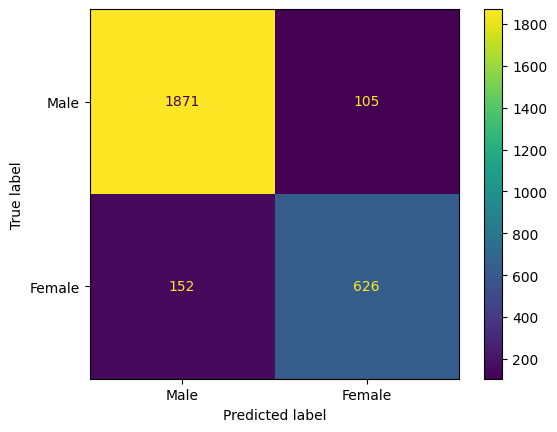

In [22]:
cm_display = ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = ['Male', 'Female'])
cm_display.plot()
plt.show()

In [23]:
#torch.save(model.state_dict(), 'custom_model.pth')